Baseline Test Loss: 0.7224
Beam Search Test Loss: 0.6632


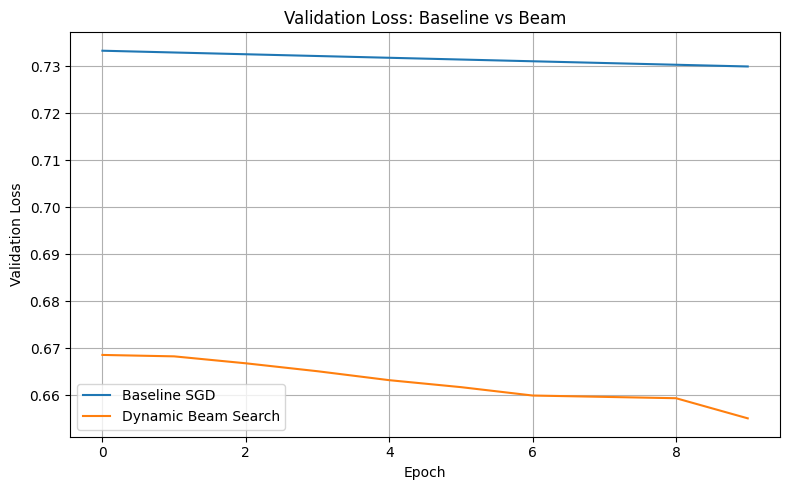

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic dataset
X, y = make_classification(n_samples=500, n_features=20, n_informative=10,
                           n_redundant=5, n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define model
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# Evaluation
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        return nn.BCELoss()(preds, y).item()

# Clone model with noise
def clone_model(model, noise_std=0.01):
    new_model = SimpleNet()
    new_model.load_state_dict(model.state_dict())
    with torch.no_grad():
        for p in new_model.parameters():
            p.add_(torch.randn_like(p) * noise_std)
    return new_model

# Baseline SGD
def train_baseline(epochs=10, lr=0.01):
    model = SimpleNet()
    opt = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        loss = nn.BCELoss()(model(X_train), y_train)
        loss.backward()
        opt.step()
        losses.append(evaluate(model, X_val, y_val))
    return model, losses

# Dynamic Beam
def train_beam(k=3, epochs=10, lr=0.01, jitter=0.01):
    beam = [SimpleNet() for _ in range(k)]
    optimizers = [optim.SGD(m.parameters(), lr=lr) for m in beam]
    losses = []

    for _ in range(epochs):
        candidates = []
        for model, opt in zip(beam, optimizers):
            model.train()
            opt.zero_grad()
            loss = nn.BCELoss()(model(X_train), y_train)
            loss.backward()
            opt.step()
            candidates.append(model)
            candidates.append(clone_model(model, noise_std=jitter))
        all_losses = [evaluate(m, X_val, y_val) for m in candidates]
        top_idx = np.argsort(all_losses)[:k]
        beam = [candidates[i] for i in top_idx]
        optimizers = [optim.SGD(m.parameters(), lr=lr) for m in beam]
        losses.append(all_losses[top_idx[0]])
    return beam[0], losses

# Train and compare
baseline_model, baseline_losses = train_baseline()
beam_model, beam_losses = train_beam()

# Test losses
baseline_test_loss = evaluate(baseline_model, X_test, y_test)
beam_test_loss = evaluate(beam_model, X_test, y_test)
print(f"Baseline Test Loss: {baseline_test_loss:.4f}")
print(f"Beam Search Test Loss: {beam_test_loss:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(baseline_losses, label='Baseline SGD')
plt.plot(beam_losses, label='Dynamic Beam Search')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss: Baseline vs Beam")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()